## 進階機器學習 HW1 
* 學號: B103040047
* 姓名: 周安

### HW1-1

Load dataset

In [127]:
from sklearn import datasets 
circles_data, circles_data_labels = datasets.make_circles(n_samples=100, factor=0.1, noise=0.1) 

In [128]:
print(circles_data[:10], circles_data_labels[:10])
print(circles_data.shape)
print(circles_data_labels.shape)

[[ 0.01004783 -0.17510486]
 [ 0.14058191  0.16717858]
 [-0.059743    0.11848299]
 [ 0.71938348 -0.59898403]
 [ 0.87586276 -0.79693694]
 [ 0.28238185 -0.8096356 ]
 [-0.88398798  0.19969581]
 [-0.04821718 -0.06689042]
 [ 0.35579647  1.02466875]
 [ 0.92202981 -0.08438964]] [1 1 1 0 0 0 0 1 0 0]
(100, 2)
(100,)


In [129]:
print(set(circles_data_labels))
# two kinds of labels

{0, 1}


In [130]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import numpy as np

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Train on {device}.")

Train on cuda.


Create a model which only contains fully-connected layers.

In [131]:
# Model
class FCL(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layers = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # output 2 label
        )
    def forward(self, x):
        return self.linear_layers(x)

In [132]:
# hyper parameters
LR = 0.0007
batch_size_train = 10
batch_size_val = 10
NUM_EPOCHS = 20

model_1 = FCL().to(device)
# set loss function
criterion = nn.CrossEntropyLoss()
# set optimizer
optimizer = torch.optim.Adam(model_1.parameters(), lr=LR, betas=(0.9, 0.999))    

Create dataloader

In [133]:
# convert np.array into torch.tensor
circles_data = torch.tensor(circles_data, dtype=torch.float32)
# Convert circles_data_labels to a tensor (ensure it's of type long for classification tasks)
circles_data_labels = torch.tensor(circles_data_labels, dtype=torch.long)

# Assuming circles_data is a list of tensors
dataset = TensorDataset(circles_data, circles_data_labels)

# Define split sizes
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = len(dataset) - train_size  # Remaining 30% for validation

# Split dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False, pin_memory=True)  # No shuffle for validation

# Check dataset sizes
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Training samples: 70, Validation samples: 30


In [134]:
# train and val func for one epoch
def train_epoch(train_dataloader):
    train_loss = 0.0
    train_acc = 0.0
    model_1.train()
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        # clear gradients
        optimizer.zero_grad()
        # predicting
        y_pred = model_1(x)
        # see loss
        loss = criterion(y_pred, y)
        loss.backward()
        # update the parameters
        optimizer.step()

        train_loss += loss.item()
        probs = torch.nn.functional.softmax(y_pred, dim=1)
        train_acc += torch.sum(torch.argmax(probs, dim=1) == y).item()
    return train_acc / len(train_dataloader.dataset), train_loss / len(train_dataloader.dataset)

def val_epoch(val_dataloader):
    val_loss = 0.0
    val_acc = 0.0
    model_1.eval()
    with torch.no_grad():
        for x, y in val_dataloader:
            x, y = x.to(device), y.to(device)
            # predicting
            y_pred = model_1(x)
            # see loss
            loss = criterion(y_pred, y)
            
            val_loss += loss.item()
            probs = torch.nn.functional.softmax(y_pred, dim=1)
            val_acc += torch.sum(torch.argmax(probs, dim=1) == y).item()
    return val_acc / len(val_dataloader.dataset), val_loss / len(val_dataloader.dataset)

In [135]:
# Start training and testing
max_accuracy = 0
for i in range(NUM_EPOCHS):
    train_acc, train_loss = train_epoch(train_dataloader)
    val_acc, val_loss = val_epoch(val_dataloader)
    
    print("Epoch[{:>2d}/{:>2d}] : train_acc = {:.4f}, train_loss = {:.4f}, val_acc = {:.4f}, val_loss = {:.4f}".format(i+1, NUM_EPOCHS, train_acc, train_loss, val_acc, val_loss))
    # update model pth when larger val_acc happens
    if(val_acc > max_accuracy):
        max_accuracy = val_acc
        save_parameters = True
        if save_parameters:
            path = 'fcl_model.pth'
            torch.save(model_1.state_dict(), path)
            print("\t\33[33m====Save model parameters in {:s} when val_acc is {:.4f}====\33[0m".format(path, val_acc))


Epoch[ 1/20] : train_acc = 0.5429, train_loss = 0.0682, val_acc = 0.6000, val_loss = 0.0666
	====Save model parameters in fcl_model.pth when val_acc is 0.6000====
Epoch[ 2/20] : train_acc = 0.9714, train_loss = 0.0557, val_acc = 1.0000, val_loss = 0.0330
	====Save model parameters in fcl_model.pth when val_acc is 1.0000====
Epoch[ 3/20] : train_acc = 1.0000, train_loss = 0.0114, val_acc = 1.0000, val_loss = 0.0002
Epoch[ 4/20] : train_acc = 0.9857, train_loss = 0.0021, val_acc = 1.0000, val_loss = 0.0009
Epoch[ 5/20] : train_acc = 0.9857, train_loss = 0.0043, val_acc = 1.0000, val_loss = 0.0000
Epoch[ 6/20] : train_acc = 0.9714, train_loss = 0.0067, val_acc = 1.0000, val_loss = 0.0000
Epoch[ 7/20] : train_acc = 0.9857, train_loss = 0.0290, val_acc = 0.9333, val_loss = 0.0371
Epoch[ 8/20] : train_acc = 0.9714, train_loss = 0.0212, val_acc = 1.0000, val_loss = 0.0006
Epoch[ 9/20] : train_acc = 0.9571, train_loss = 0.0115, val_acc = 1.0000, val_loss = 0.0013
Epoch[10/20] : train_acc = 1.0

Load back the best model

In [136]:
model_test = FCL()
# Move model to device
model_test.to(device)
pth_path = path
state_dict = torch.load(pth_path)
model_test.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")

Load pth from fcl_model.pth


Draw the distribution image

In [137]:
# Create a dense grid of (x, y) points
x_min, x_max = circles_data[:, 0].min() - 0.2, circles_data[:, 0].max() + 0.2
y_min, y_max = circles_data[:, 1].min() - 0.2, circles_data[:, 1].max() + 0.2
# Create 200x200 x-coordinates and y-coordinates
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
# xx's shape is [200, 200]

# Convert this gridpoints into dataloader for predicting
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32) # np.c_ means concatenate. Here concatenate x and y data
test_dataset = TensorDataset(grid_points, torch.tensor(np.array([0 for i in range(len(grid_points))]), dtype=torch.long))
test_dataloader = DataLoader(test_dataset, batch_size=200, shuffle=False, pin_memory=True)  # No shuffle for validation

print(grid_points.shape)

# Initialize the list
predicted_classes = []
# Set the model to evaluation mode
model_test.eval()
# Perform prediction without calculating gradients
with torch.no_grad():
    for x, _ in test_dataloader:
        x = x.to(device)
        predictions = model_test(x)
        
        # Get the predicted class (index of maximum probability)
        predicted_classes.append(torch.argmax(predictions.cpu(), dim=1).numpy())

# Concatenate the list of predictions into a single NumPy array
predicted_classes = np.concatenate(predicted_classes)

# Reshape the predictions to match the grid shape
predicted_classes = predicted_classes.reshape(xx.shape)

print(predicted_classes.shape)


torch.Size([40000, 2])
(200, 200)


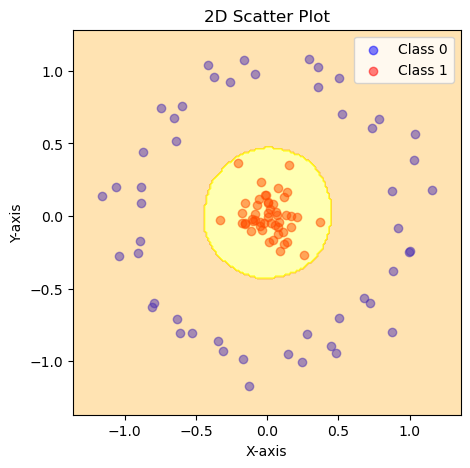

In [138]:
import matplotlib.pyplot as plt
# Create a custom colormap using the listed colors
from matplotlib.colors import ListedColormap
custom_colors = ['orange', 'yellow']  # Add more colors as needed
cmap = ListedColormap(custom_colors)

circles_data_0 = circles_data[circles_data_labels == 0]
circles_data_1 = circles_data[circles_data_labels == 1]
plt.figure(figsize=(5, 5))
# draw scatter image
plt.scatter(circles_data_0[:, 0], circles_data_0[:, 1], color='blue', alpha=0.5, label="Class 0")
plt.scatter(circles_data_1[:, 0], circles_data_1[:, 1], color='red', alpha=0.5, label="Class 1")
plt.contourf(xx, yy, predicted_classes, cmap=cmap, alpha=0.3)  # Background color

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("2D Scatter Plot")

# Add legend to explain color coding
plt.legend(loc="upper right")
plt.show()

### HW1-2

In [139]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 1, 3)
        self.linear = nn.Linear(4, 2) # binary classfication
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.conv(x)
        x = self.sigmoid(x)
        x = x.view(-1, 4)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [140]:
# hyper parameters
LR = 0.001
batch_size_train = 1
# batch_size_val = 10
NUM_EPOCHS = 10

model_2 = CNN().to(device)
# set loss function
criterion_2 = nn.CrossEntropyLoss()
# set optimizer
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=LR, betas=(0.9, 0.999))    

In [141]:
print(model_2)

CNN(
  (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
  (linear): Linear(in_features=4, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)


Create a random data.

In [142]:
# create a tensor which is 4x4
# Dummy input (batch_size = 1, channels=1, height=4, width=4)
A = torch.randn(1, 1, 4, 4)
print("A.shape is", A.shape)
print(A)

# yy is correct label
yy = torch.randint(0, 2, (1, ), dtype=torch.long) # 0 or 1
print("yy.shape is", yy.shape)
print(yy)
A_dataset = TensorDataset(A, yy)
A_dataloader = DataLoader(A_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=False)

A.shape is torch.Size([1, 1, 4, 4])
tensor([[[[-0.9862, -1.2283,  1.7308,  1.0227],
          [-1.8497, -0.3047,  0.6087,  1.5734],
          [-1.2728, -0.0041, -0.7761,  1.4426],
          [ 0.4690,  0.2230, -0.6563,  0.6814]]]])
yy.shape is torch.Size([1])
tensor([1])


In [143]:
print(len(A_dataloader))
print(A_dataloader.batch_size)

1
1


In [144]:
# check the dataloader info
for a, y in A_dataloader:
    print(a, y)
    break

tensor([[[[-0.9862, -1.2283,  1.7308,  1.0227],
          [-1.8497, -0.3047,  0.6087,  1.5734],
          [-1.2728, -0.0041, -0.7761,  1.4426],
          [ 0.4690,  0.2230, -0.6563,  0.6814]]]]) tensor([1])


#### 1. Get the gradient of the loss with respect to the weight w00

In [145]:
# train and val func for one epoch
def train_epoch_2(train_dataloader):
    train_loss = 0.0
    train_acc = 0.0
    model_2.train()
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        # clear gradients
        optimizer_2.zero_grad()
        # predicting
        y_pred = model_2(x)
        # see loss
        loss = criterion_2(y_pred, y)
        loss.backward()

        # In each epoch, we can get the gradient with regard to weight which .requires_grad_() automatically.
        # Access the gradient of w00 (top-left element in the 3x3 kernel)
        w00_grad = model_2.conv.weight.grad[0, 0, 0, 0]  # (out_channels, in_channels, kernel_h, kernel_w)

        print("\33[33m2-1. The gradient of the loss with respect to the weight w00: {:.6f}\33[0m".format(w00_grad.item()))
        # update the parameters
        optimizer_2.step()

        train_loss += loss.item()
        probs = torch.nn.functional.softmax(y_pred, dim=1)
        train_acc += torch.sum(torch.argmax(probs, dim=1) == y).item()
    return train_acc / len(train_dataloader.dataset), train_loss / len(train_dataloader.dataset)


In [146]:
# Start training to calculate the gradient
for i in range(NUM_EPOCHS): # train some epochs
    train_acc, train_loss = train_epoch_2(A_dataloader)
    print("Epoch[{:>2d}/{:>2d}] : train_acc = {:.4f}, train_loss = {:.4f}".format(i+1, NUM_EPOCHS, train_acc, train_loss))

2-1. The gradient of the loss with respect to the weight w00: -0.032146
Epoch[ 1/10] : train_acc = 0.0000, train_loss = 0.6944
2-1. The gradient of the loss with respect to the weight w00: -0.031821
Epoch[ 2/10] : train_acc = 0.0000, train_loss = 0.6933
2-1. The gradient of the loss with respect to the weight w00: -0.031497
Epoch[ 3/10] : train_acc = 1.0000, train_loss = 0.6923
2-1. The gradient of the loss with respect to the weight w00: -0.031173
Epoch[ 4/10] : train_acc = 1.0000, train_loss = 0.6913
2-1. The gradient of the loss with respect to the weight w00: -0.030849
Epoch[ 5/10] : train_acc = 1.0000, train_loss = 0.6903
2-1. The gradient of the loss with respect to the weight w00: -0.030526
Epoch[ 6/10] : train_acc = 1.0000, train_loss = 0.6893
2-1. The gradient of the loss with respect to the weight w00: -0.030204
Epoch[ 7/10] : train_acc = 1.0000, train_loss = 0.6883
2-1. The gradient of the loss with respect to the weight w00: -0.029882
Epoch[ 8/10] : train_acc = 1.0000, trai

In [147]:
print(optimizer_2.param_groups)

[{'params': [Parameter containing:
tensor([[[[ 0.3012, -0.0695,  0.2053],
          [ 0.0865, -0.2857,  0.1909],
          [-0.0466,  0.0139,  0.2163]]]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.3025], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[ 0.0428,  0.3035,  0.2705, -0.4848],
        [-0.0076,  0.2998, -0.3362,  0.2493]], device='cuda:0',
       requires_grad=True), Parameter containing:
tensor([ 0.0479, -0.1763], device='cuda:0', requires_grad=True)], 'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None}]


See the shape of weight and gradient.

In [148]:
print(model_2.conv.weight)
print(model_2.conv.weight.shape)

print(model_2.conv.weight.grad)
print(model_2.conv.weight.grad.shape)
# The shape is [1,1,3,3] because conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)

Parameter containing:
tensor([[[[ 0.3012, -0.0695,  0.2053],
          [ 0.0865, -0.2857,  0.1909],
          [-0.0466,  0.0139,  0.2163]]]], device='cuda:0', requires_grad=True)
torch.Size([1, 1, 3, 3])
tensor([[[[-0.0292, -0.0173, -0.0130],
          [-0.0253,  0.0127, -0.0368],
          [ 0.0025,  0.0149, -0.0241]]]], device='cuda:0')
torch.Size([1, 1, 3, 3])


#### 2. Get the gradient of the loss with respect to the input feature a21, as shown in the figure below.

In [149]:
# hyper parameters
LR = 0.001
batch_size_train = 1
# batch_size_val = 10
NUM_EPOCHS = 10

model_3 = CNN().to(device)
# set loss function
criterion_3 = nn.CrossEntropyLoss()
# set optimizer
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=LR, betas=(0.9, 0.999))    

In [150]:
# train and val func for one epoch
def train_epoch_3(train_dataloader):
    train_loss = 0.0
    train_acc = 0.0
    model_3.train()
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        # want to calculate grad with regard to input
        x.requires_grad_() 
        # clear gradients
        optimizer_3.zero_grad()
        # predicting
        y_pred = model_3(x)
        # see loss
        loss = criterion_3(y_pred, y)
        loss.backward()

        # See the gradient with regard to x
        a21_grad = x.grad[0, 0, 2, 1].item()
        print("\33[33m2-2. The gradient of the loss with respect to the input feature a21: {:.6f}\33[0m".format(a21_grad))
        # x.grad is torch.Size([batch_size, 1, 4, 4])
        
        # update the parameters
        optimizer_3.step()

        train_loss += loss.item()
        probs = torch.nn.functional.softmax(y_pred, dim=1)
        train_acc += torch.sum(torch.argmax(probs, dim=1) == y).item()
    return train_acc / len(train_dataloader.dataset), train_loss / len(train_dataloader.dataset)


In [151]:
# Start training to calculate the gradient
for i in range(NUM_EPOCHS): # train some epochs
    train_acc, train_loss = train_epoch_3(A_dataloader)
    print("Epoch[{:>2d}/{:>2d}] : train_acc = {:.4f}, train_loss = {:.4f}".format(i+1, NUM_EPOCHS, train_acc, train_loss))

2-2. The gradient of the loss with respect to the input feature a21: 0.002468
Epoch[ 1/10] : train_acc = 0.0000, train_loss = 0.9246
2-2. The gradient of the loss with respect to the input feature a21: 0.002507
Epoch[ 2/10] : train_acc = 0.0000, train_loss = 0.9234
2-2. The gradient of the loss with respect to the input feature a21: 0.002546
Epoch[ 3/10] : train_acc = 0.0000, train_loss = 0.9222
2-2. The gradient of the loss with respect to the input feature a21: 0.002585
Epoch[ 4/10] : train_acc = 0.0000, train_loss = 0.9211
2-2. The gradient of the loss with respect to the input feature a21: 0.002623
Epoch[ 5/10] : train_acc = 0.0000, train_loss = 0.9199
2-2. The gradient of the loss with respect to the input feature a21: 0.002661
Epoch[ 6/10] : train_acc = 0.0000, train_loss = 0.9187
2-2. The gradient of the loss with respect to the input feature a21: 0.002698
Epoch[ 7/10] : train_acc = 0.0000, train_loss = 0.9175
2-2. The gradient of the loss with respect to the input feature a21: 